# Debiasing Word Embeddings

# Set Up

In [46]:
!pip install pandas numpy seaborn scipy datasets gensim fasttext adjustText stable_baselines3 shimmy>=0.2.1 datasets fasttext

In [47]:
import numpy as np
from datasets import load_dataset
from scipy.spatial.distance import cosine
import re
from gensim.models import KeyedVectors
import fasttext
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from adjustText import adjust_text

In [48]:
primary_gendered_keywords = {'he', 'she', 'his', 'her', 'him', 'hers', 'himself', 'herself', 'man', 'woman', 'male', 'female', 'boy', 'girl', 'son', 'daughter', 'gentleman', 'lady'}
secondary_gendered_keywords = {'father', 'mother', 'king', 'queen', 'brother', 'sister', 'husband', 'wife', 'grandfather', 'grandmother', 'uncle', 'aunt', 'nephew', 'niece', 'boyfriend', 'girlfriend', 'male cousin', 'female cousin', 'father-in-law', 'mother-in-law', 'son-in-law', 'daughter-in-law', 'brother-in-law', 'sister-in-law'}
professional_titles = {'engineer', 'doctor', 'teacher', 'nurse', 'lawyer', 'architect', 'accountant', 'mechanic', 'chef', 'scientist', 'researcher', 'therapist', 'pharmacist', 'dentist', 'psychologist', 'veterinarian', 'electrician', 'plumber', 'journalist', 'pilot', 'painter', 'carpenter', 'actor', 'director', 'producer', 'musician', 'writer', 'politician', 'judge', 'police officer', 'firefighter', 'military officer', 'salesperson', 'marketing manager', 'product manager', 'software developer', 'web designer', 'graphic designer', 'consultant', 'financial analyst', 'banker', 'teacher assistant', 'professor', 'lecturer', 'dean', 'school counselor', 'librarian', 'coach', 'personal trainer'}  # Expanded set
neutral_terms = {'office', 'tool', 'meeting', 'computer', 'desk', 'report', 'presentation', 'conference', 'project', 'task', 'deadline', 'schedule', 'email', 'communication', 'team', 'management', 'leadership', 'strategy', 'negotiation', 'analysis', 'research', 'data', 'budget', 'plan', 'goal', 'performance', 'innovation', 'collaboration'}
control_words = {'tree', 'river', 'mountain', 'ocean', 'cloud', 'rock', 'forest', 'desert', 'planet', 'star', 'galaxy', 'moon', 'sun', 'earth', 'water', 'fire', 'air', 'nature', 'animal', 'bird', 'fish', 'flower', 'grass', 'leaf', 'seed', 'soil', 'rain', 'storm', 'snow', 'wind'}

male_keywords = {'he', 'his', 'him', 'himself', 'man', 'male', 'boy', 'son', 'gentleman', 'father', 'king', 'brother', 'husband', 'grandfather', 'uncle', 'nephew', 'boyfriend', 'male cousin', 'father-in-law', 'son-in-law', 'brother-in-law'}
female_keywords = {'she', 'her', 'hers', 'herself', 'woman', 'female', 'girl', 'daughter', 'lady', 'mother', 'queen', 'sister', 'wife', 'grandmother', 'aunt', 'niece', 'girlfriend', 'female cousin', 'mother-in-law', 'daughter-in-law', 'sister-in-law'}

def get_vector(embeddings, word):
    return embeddings.get(word, None)

def get_existing_titles(current_embeddings):
    existing_titles = []
    for title in professional_titles:
        if get_vector(current_embeddings, title) is not None:
          existing_titles.append(title)
    return existing_titles

# Bias Analysis Helper Functions


In [49]:
def mean_vector(embedding, words):
    vectors = [embedding.get(word, None) for word in words]
    vectors = [v for v in vectors if v is not None]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(len(vectors[0]))

def plot_gender_direction_projection(embedding, professional_titles, gender_direction, reference_words=['he', 'she'], leftlim=-0.3, rightlim=0.3):

    def project_on_gender_direction(word):
      if word in embedding:
          word_vector = embedding[word]
      else:
          word_vector = None
      if word_vector is not None:
          return np.dot(word_vector, gender_direction)
      else:
          return 0

    projections = {word: project_on_gender_direction(word)
                   for word in professional_titles if word in embedding}

    plt.figure(figsize=(10, 5))

    texts = []
    for word, projection in projections.items():
        plt.scatter(projection, 0, alpha=0.5)
        texts.append(plt.text(projection, 0, word, fontsize=8))

    plt.scatter(project_on_gender_direction(reference_words[0]), 0, color='red', label='He', alpha=0.75)
    plt.scatter(project_on_gender_direction(reference_words[1]), 0, color='blue', label='She', alpha=0.75)

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    plt.title('Projection of Professional Titles onto Gender Direction')
    plt.xlabel('Projection onto Gender Direction')
    plt.ylabel('Neutral Axis (0)')
    plt.legend()
    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xlim(leftlim, rightlim)
    plt.show()

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def generate_cosine_similarity_heatmap(words, embeddings, reference_words=['he', 'she']):
    ref_vector = np.subtract(embeddings[reference_words[0]], embeddings[reference_words[1]])
    ref_vector = ref_vector.reshape(1, -1)

    vectors = np.array([embeddings[word] for word in words if word in embeddings])
    existing_words = []
    for word in words:
      if word in embeddings:
        existing_words.append(word)

    cos_sim_matrix = cosine_similarity(vectors, ref_vector)

    sns.set(style='white')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim_matrix, xticklabels=['bias'], yticklabels=existing_words, cmap='coolwarm', annot=True)
    plt.title('Cosine Similarity Heatmap between Words and Gendered Terms')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [51]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def analyze_gender_bias_in_embeddings(professional_titles, gender_direction, embeddings):
    def project_on_gender_direction(word, gender_direction):
        return np.dot(embeddings.get(word, np.zeros_like(gender_direction)), gender_direction) / np.linalg.norm(gender_direction)

    profession_projections = {word: project_on_gender_direction(word, gender_direction)
                              for word in professional_titles if word in embeddings}

    male_projections = [project_on_gender_direction(word, gender_direction)
                        for word in professional_titles
                        if word in embeddings and embeddings.get(word) is not None]
    female_projections = [-project_on_gender_direction(word, gender_direction)
                          for word in professional_titles
                          if word in embeddings and embeddings.get(word) is not None]

    print('Male projections normality:', stats.shapiro(male_projections))
    print('Female projections normality:', stats.shapiro(female_projections))

    u_statistic, p_value = stats.mannwhitneyu(male_projections, female_projections)
    print('Mann-Whitney U test p-value:', p_value)

    data_to_plot = [male_projections, female_projections]
    plt.boxplot(data_to_plot, labels=['Male', 'Female'])
    plt.title('Distribution of Projections onto Gender Direction')
    plt.ylabel('Projection Score')
    plt.show()

In [52]:
def cosine_similarity_cf(vec_a, vec_b):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

def average_cosine_similarity(embeddings1, embeddings2, words):
    """Calculate average cosine similarity between corresponding words in two embeddings."""
    similarities = []
    for word in words:
        if word in embeddings1 and word in embeddings2:
            vec_a = embeddings1[word]
            vec_b = embeddings2[word]
            similarity = cosine_similarity_cf(vec_a, vec_b)
            similarities.append(similarity)
    if similarities:
        return np.mean(similarities)
    else:
        return 0

# Embeddings Analysis (Optional)

## GloVe Embeddings

### Loading Data

In [ ]:
import numpy as np

def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            normalized_vector = vector / np.linalg.norm(vector)
            embeddings[word] = normalized_vector
    return embeddings

embeddings_file_path = '/content/drive/MyDrive/ProjectData/glove.twitter.27B.200d.txt'
current_embeddings = load_glove_embeddings(embeddings_file_path)
existing_titles = get_existing_titles(current_embeddings)

### Bias Visualization: Graph

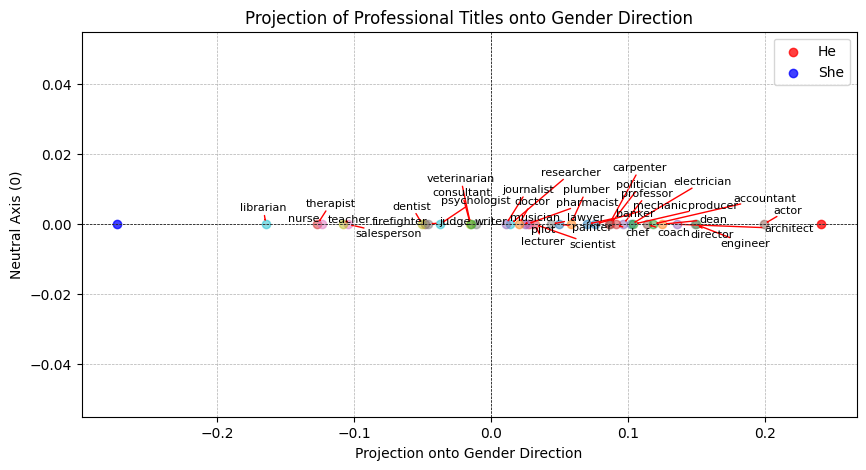

In [ ]:
male_vector = mean_vector(current_embeddings, male_keywords)
female_vector = mean_vector(current_embeddings, female_keywords)

gender_direction = male_vector - female_vector

plot_gender_direction_projection(current_embeddings, existing_titles, gender_direction)

### Bias Visualization: Heat-Map

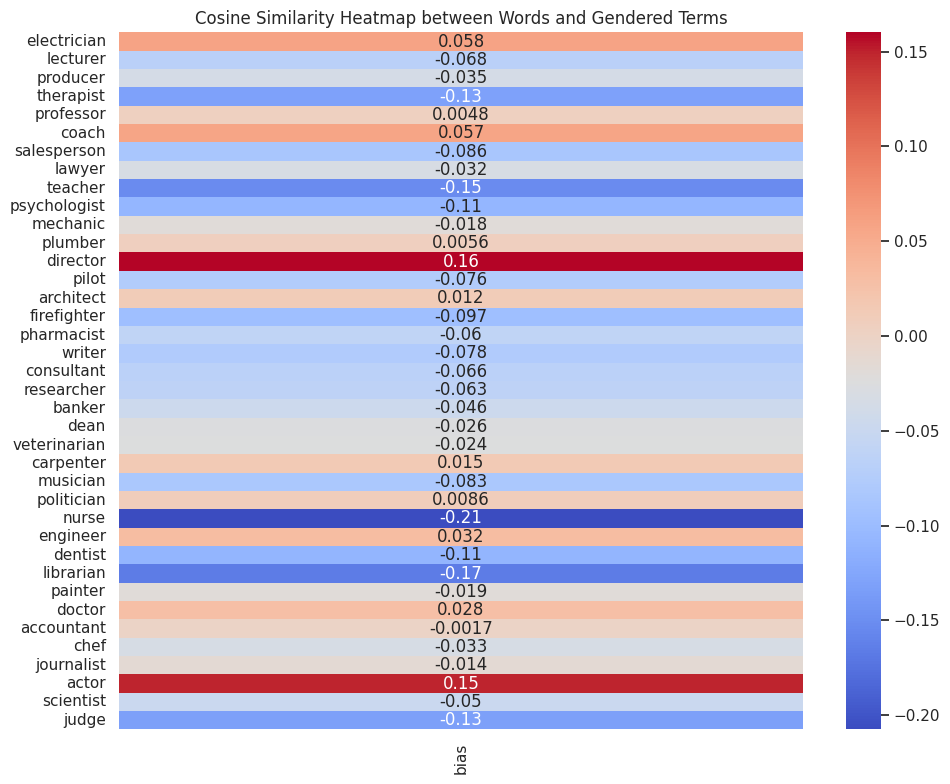

In [ ]:
generate_cosine_similarity_heatmap(existing_titles, current_embeddings)

### Bias Tests

Male projections normality: ShapiroResult(statistic=0.9726935029029846, pvalue=0.46907100081443787)
Female projections normality: ShapiroResult(statistic=0.9726932048797607, pvalue=0.4690612554550171)
Mann-Whitney U test p-value: 0.0032274642277154405


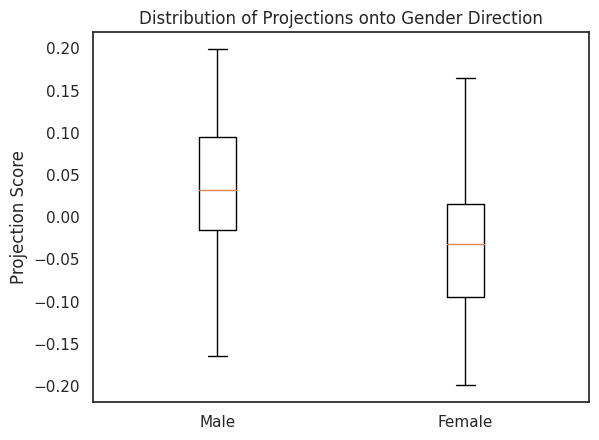

In [ ]:
analyze_gender_bias_in_embeddings(professional_titles, gender_direction, current_embeddings)

## Word2Vec Embeddings

### Loading Data

In [ ]:
import numpy as np
from gensim.models import KeyedVectors

def load_word2vec_embeddings(filepath):
    model = KeyedVectors.load_word2vec_format(filepath, binary=True)
    embeddings = {}
    for word in model.key_to_index.keys():
        vector = model[word]
        normalized_vector = vector / np.linalg.norm(vector)
        embeddings[word] = normalized_vector
    return embeddings

word2vec_file_path = '/content/drive/MyDrive/ProjectData/GoogleNews-vectors-negative300.bin'
current_embeddings = load_word2vec_embeddings(word2vec_file_path)
existing_titles = get_existing_titles(current_embeddings)

### Bias Visualization: Graph

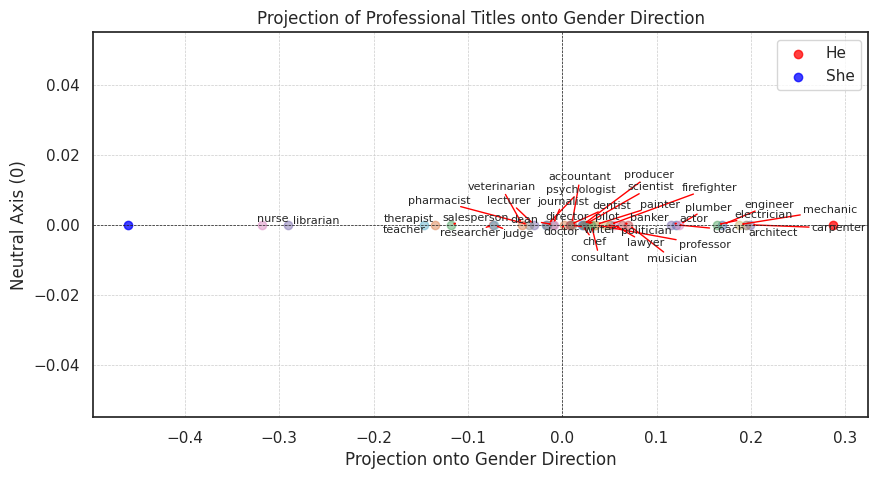

In [ ]:
male_vector = mean_vector(current_embeddings, male_keywords)
female_vector = mean_vector(current_embeddings, female_keywords)

gender_direction = male_vector - female_vector

plot_gender_direction_projection(current_embeddings, professional_titles, gender_direction)

### Bias Visualization: Heat-Map

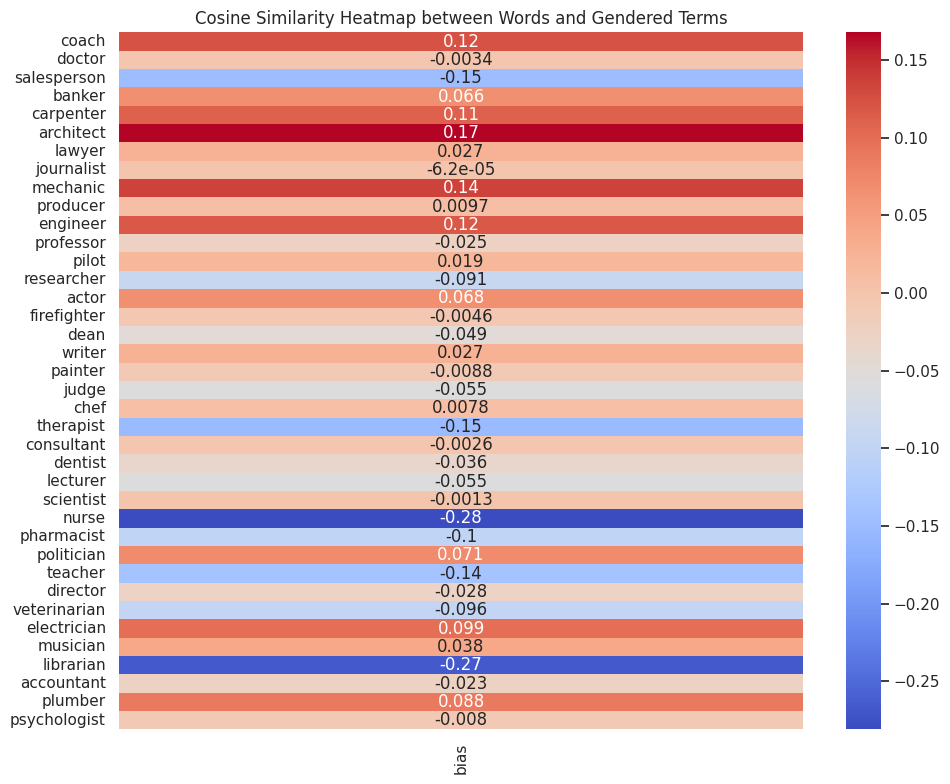

In [ ]:
generate_cosine_similarity_heatmap(existing_titles, current_embeddings)

### Bias Tests

Male projections normality: ShapiroResult(statistic=0.9253542423248291, pvalue=0.014359108172357082)
Female projections normality: ShapiroResult(statistic=0.9253542423248291, pvalue=0.014359108172357082)
Mann-Whitney U test p-value: 0.07480405200084338


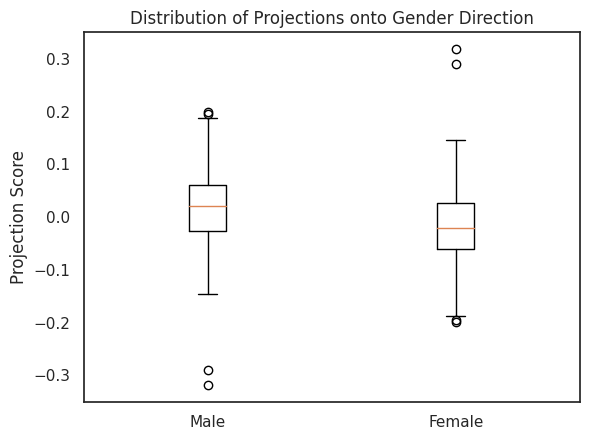

In [ ]:
analyze_gender_bias_in_embeddings(professional_titles, gender_direction, current_embeddings)

## FastText Embeddings




### Load Data

In [ ]:
import fasttext
import fasttext.util
import numpy as np

def load_fasttext_binary_embeddings(filepath):
    model = fasttext.load_model(filepath)
    embeddings = {}
    for word in model.words:
        vector = model.get_word_vector(word)
        normalized_vector = vector / np.linalg.norm(vector)
        embeddings[word] = normalized_vector
    return embeddings

fasttext_file_path = '/content/drive/MyDrive/ProjectData/cc.en.300.bin'
current_embeddings = load_fasttext_binary_embeddings(fasttext_file_path)
existing_titles = get_existing_titles(current_embeddings)

### Bias Visualization: Graph

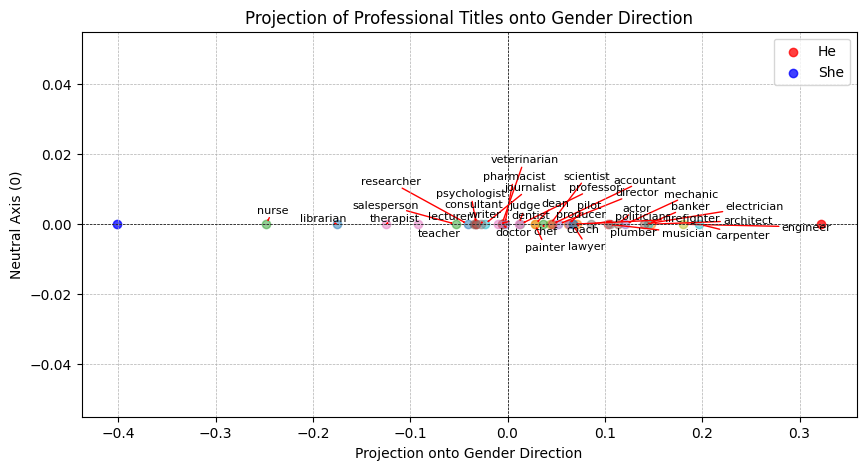

In [ ]:
male_vector = mean_vector(current_embeddings, male_keywords)
female_vector = mean_vector(current_embeddings, female_keywords)

gender_direction = male_vector - female_vector

plot_gender_direction_projection(current_embeddings, professional_titles, gender_direction)

### Bias Visualization: Heat-Map

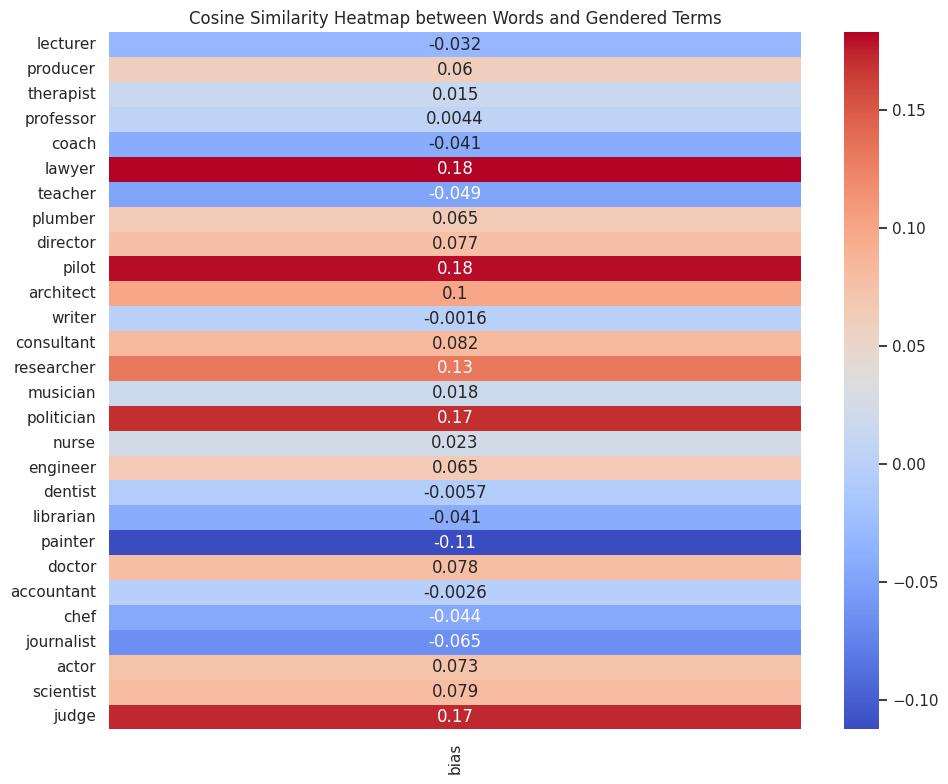

In [ ]:
generate_cosine_similarity_heatmap(existing_titles, current_embeddings)

### Bias Tests

Male projections normality: ShapiroResult(statistic=0.9645046591758728, pvalue=0.2650536596775055)
Female projections normality: ShapiroResult(statistic=0.9645048379898071, pvalue=0.2650570869445801)
Mann-Whitney U test p-value: 0.002916868130890022


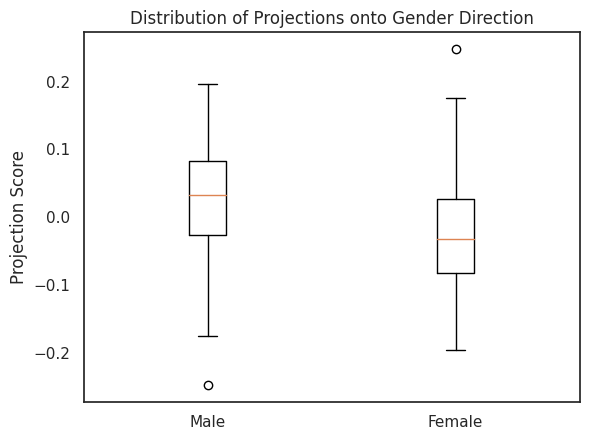

In [ ]:
analyze_gender_bias_in_embeddings(professional_titles, gender_direction, current_embeddings)

# Algorithm: Data Processing

## Data Analysis

In [70]:
dataset = load_dataset("keirp/common_crawl_sample")
words_of_interest = ["doctor", "nurse", "engineer", "teacher", "chef", "scientist", "lawyer", "judge", "mechanic", "carpenter", "artist", "musician", "writer", "actor", "director", "pilot", "sailor", "politician", "executive", "secretary", "receptionist", "waiter", "waitress", "janitor", "plumber", "electrician", "gardener", "librarian", "photographer", "designer", "developer", "analyst", "consultant", "manager", "salesperson", "officer", "soldier", "guard", "farmer", "miner", "fisherman", "architect", "pharmacist", "dentist", "physiotherapist", "psychologist", "veterinarian", "professor", "accountant", "auditor", "broker", "editor", "reporter", "meteorologist", "astronomer", "biologist", "chemist", "physicist", "intelligent", "brilliant", "creative", "diligent", "lazy", "clumsy", "competent", "skilled", "unskilled", "innovative", "charismatic", "caring", "rude", "polite", "strong", "weak", "emotional", "stoic", "confident", "insecure", "assertive", "passive", "soccer", "basketball", "chess", "video games", "knitting", "sewing", "painting", "writing", "gardening", "fishing", "hunting", "golfing", "running", "yoga", "dancing", "singing", "cooking", "baking", "reading", "traveling", "photography", "blogging", "coding", "acting", "swimming", "cycling", "beautiful", "handsome", "tall", "short", "slim", "fat", "youthful", "old", "attractive", "unattractive", "elegant", "sloppy", "neat", "fit", "muscular", "plump", "petite", "rugged", "plain", "gorgeous", "mother", "father", "sister", "brother", "daughter", "son", "aunt", "uncle", "grandmother", "grandfather", "wife", "husband", "partner", "friend", "colleague", "mentor", "protégé", "rival", "ally", "nemesis", "wealthy", "poor", "middle-class", "educated", "uneducated", "blue-collar", "white-collar", "academic", "scholar", "dropout", "apprentice", "intern", "CEO", "laborer", "unemployed", "entrepreneur", "innovator", "philanthropist", "activist", "volunteer"]  # Example words

In [71]:
def preprocess_and_save(dataset, filename="openwebtext.txt"):
    with open(filename, "w", encoding="utf-8") as f:
        for item in dataset["train"]:
            if item.get('clean', False):
                text = item['text']
                text = text.replace('\n', ' ')
                f.write(text + '\n')

preprocess_and_save(dataset)
normal_corpus = '/content/openwebtext.txt'

In [72]:
import fasttext

# Train the FastText model
model = fasttext.train_unsupervised(normal_corpus, model='skipgram', minCount=5, verbose=2)

# Save the trained model
model.save_model("openwebtext_embeddings.bin")

In [73]:
import numpy as np
import fasttext

def load_and_normalize_embeddings(model_path):
    """
    Load a FastText model, normalize its word embeddings, and optionally filter the words.

    Parameters:
    - model_path (str): Path to the FastText model file.
    - specific_words (list, optional): A list of words for which embeddings should be returned. If None, embeddings for all words are returned.

    Returns:
    dict: A dictionary mapping words to their normalized embeddings.
    """
    # Load the FastText model
    model = fasttext.load_model(model_path)

    # Function to normalize vectors
    def normalize_vector(v):
        norm = np.linalg.norm(v)
        if norm == 0:
            return v
        return v / norm

    # Extract and normalize word vectors
    embeddings = {word: normalize_vector(model.get_word_vector(word)) for word in model.get_words()}

    return embeddings


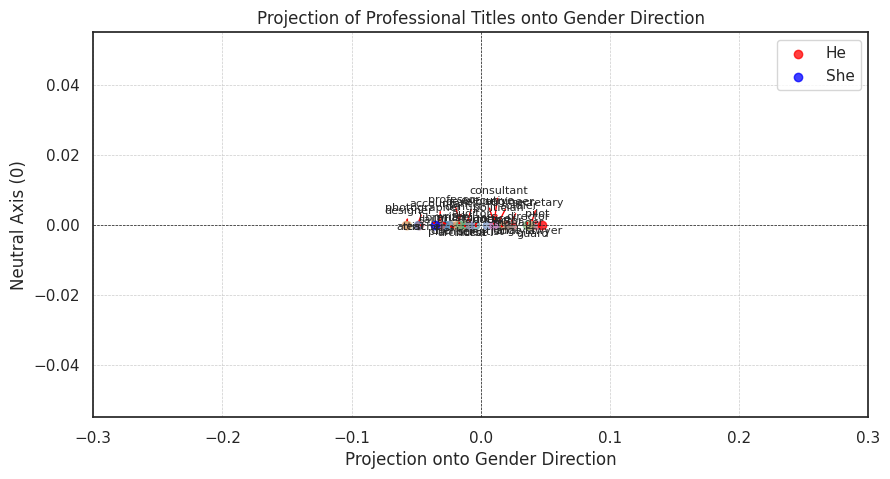

In [74]:
model_path = "openwebtext_embeddings.bin"  # Update with the correct path
current_embeddings = load_and_normalize_embeddings(model_path)

filtered_embeddings = {word: current_embeddings[word] for word in words_of_interest if word in current_embeddings}

male_vector = mean_vector(current_embeddings, male_keywords)
female_vector = mean_vector(current_embeddings, female_keywords)

gender_direction = male_vector - female_vector

plot_gender_direction_projection(current_embeddings, words_of_interest[:50], gender_direction, ['he', 'she'])

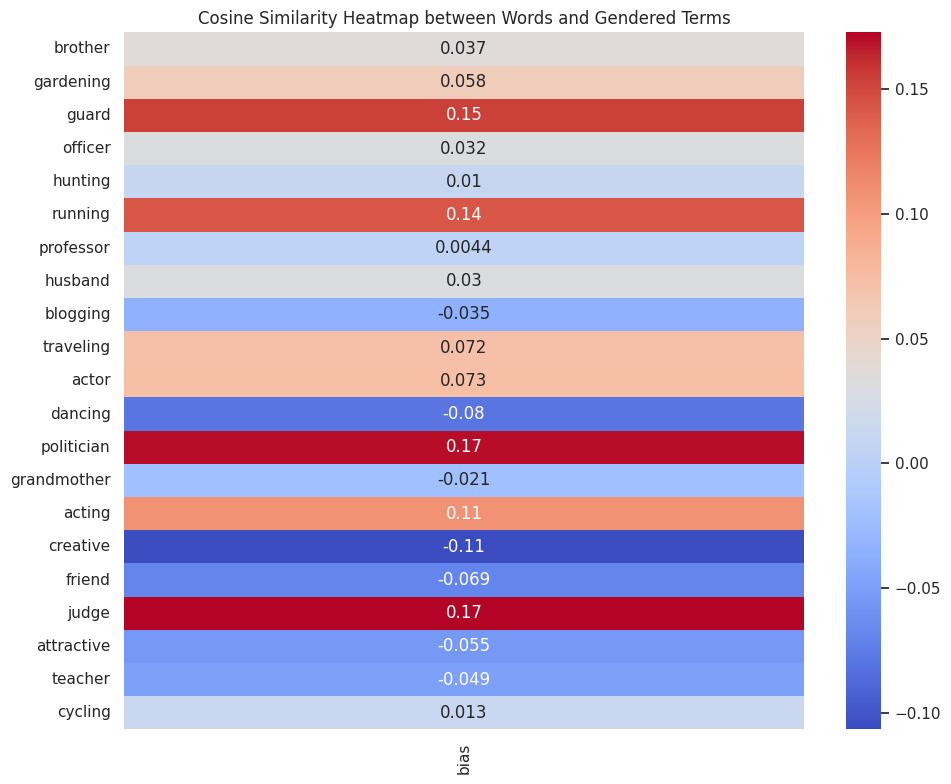

In [68]:
generate_cosine_similarity_heatmap(final_words[:21], current_embeddings)

Male projections normality: ShapiroResult(statistic=0.9894337058067322, pvalue=0.46033933758735657)
Female projections normality: ShapiroResult(statistic=0.9894343018531799, pvalue=0.4603864848613739)
Mann-Whitney U test p-value: 2.7501055383657927e-09


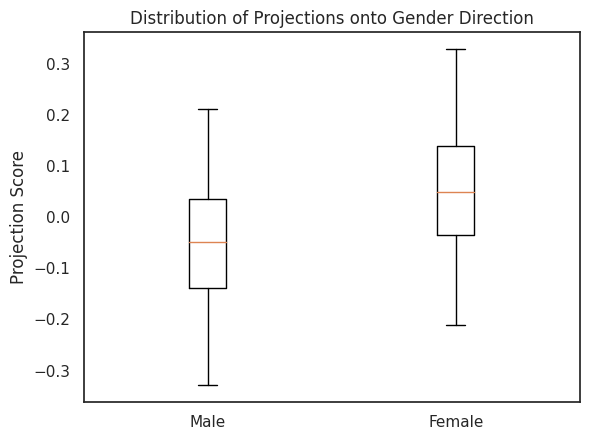

In [15]:
analyze_gender_bias_in_embeddings(words_of_interest, gender_direction, current_embeddings)

## Soft Debiasing

In [16]:
def soft_debias(embeddings, gender_direction, neutral_words):
    """Applies soft debiasing to the embeddings."""
    debiased_embeddings = {}
    for word in embeddings.keys():
        if word in embeddings:
            word_vec = embeddings[word]
            debiased_vec = word_vec - np.dot(word_vec, gender_direction) / np.linalg.norm(gender_direction) ** 2 * gender_direction
            debiased_embeddings[word] = debiased_vec
    return debiased_embeddings

male_vector = mean_vector(current_embeddings, male_keywords)
female_vector = mean_vector(current_embeddings, female_keywords)

gender_direction = male_vector - female_vector

debiased_embeddings = soft_debias(current_embeddings, gender_direction, neutral_terms)

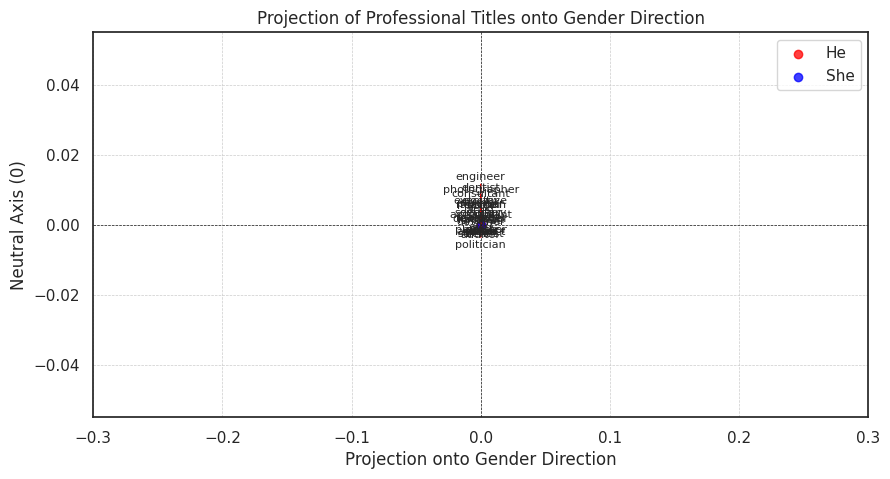

In [17]:
plot_gender_direction_projection(debiased_embeddings, words_of_interest[:50], gender_direction, ['he', 'she'])

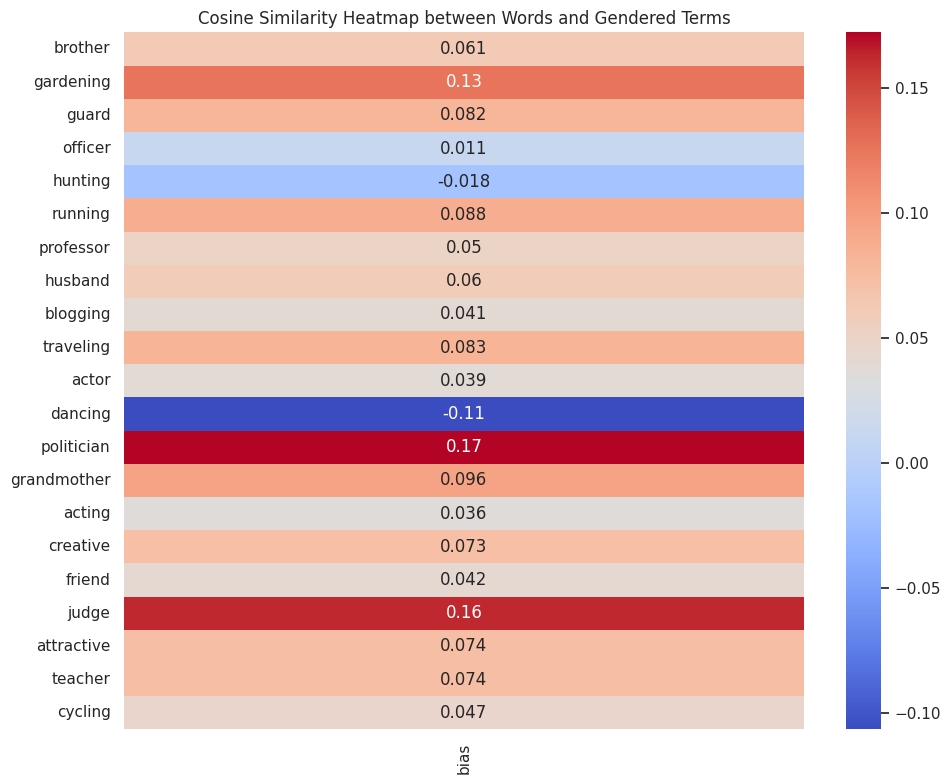

In [66]:
generate_cosine_similarity_heatmap(final_words[:21], debiased_embeddings)

In [19]:
average_cosine_similarity(current_embeddings, debiased_embeddings, words_of_interest)

0.9909998

## Counter Factual Analysis

In [21]:
import fasttext

model_counter_fact = fasttext.train_unsupervised('/content/geneval-sentences-both-dev.en_ar.en', model='skipgram')

model_counter_fact.save_model("counter_fact.bin")

0.08964257
0.03883768


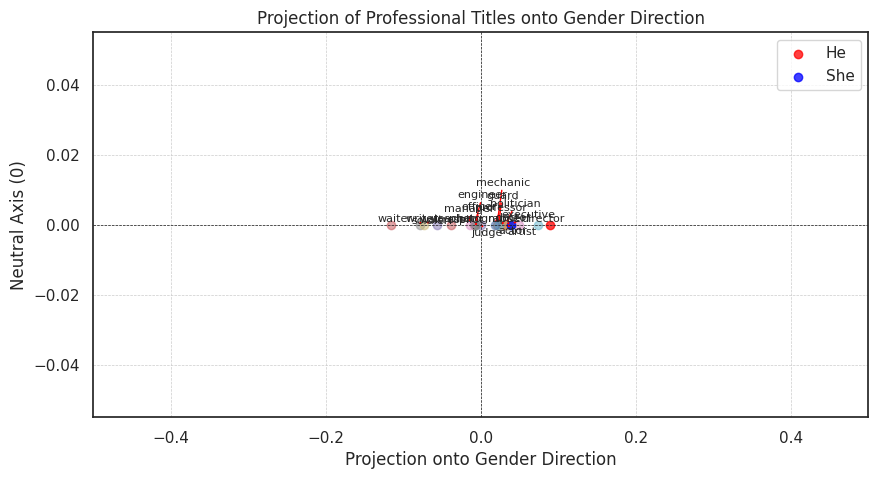

In [42]:
model_path = "counter_fact.bin"
counter_fact_embeddings = load_and_normalize_embeddings(model_path)

actual_words = []
for word in words_of_interest:
    if word in counter_fact_embeddings:
      actual_words.append(word)


male_vector = mean_vector(counter_fact_embeddings, male_keywords)
female_vector = mean_vector(counter_fact_embeddings, female_keywords)

# Calculate the gender direction vector
gender_direction = male_vector - female_vector

plot_gender_direction_projection(counter_fact_embeddings, actual_words[:21], gender_direction, ["he", "she"], -0.5, 0.5)

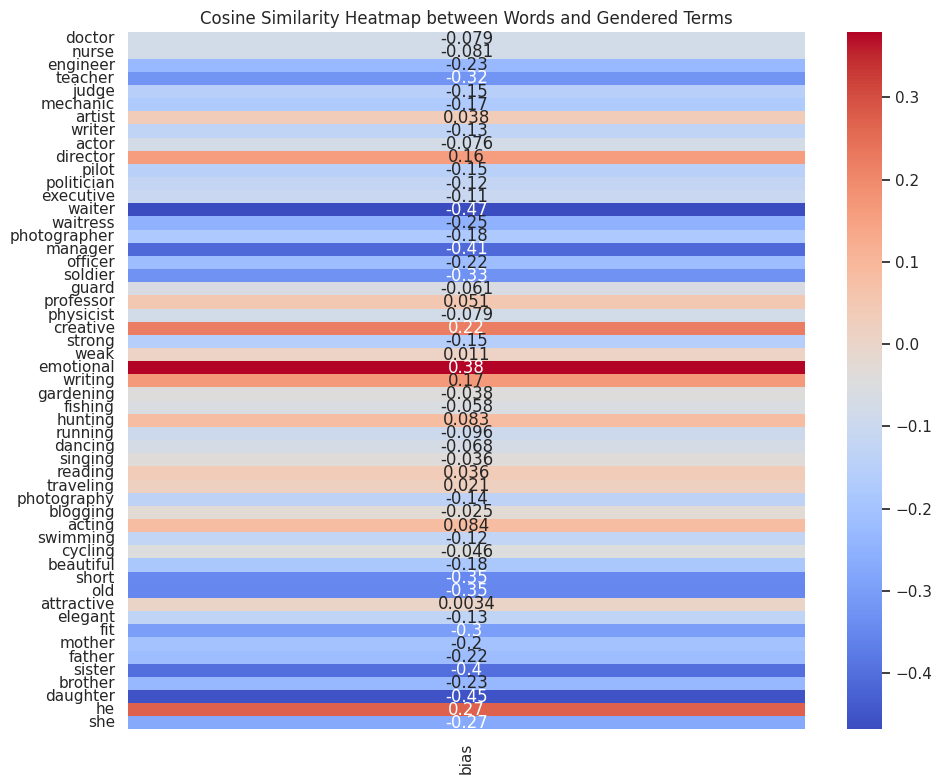

In [23]:
generate_cosine_similarity_heatmap(actual_words[:51] + ['he'] + ['she'], counter_fact_embeddings)

Male projections normality: ShapiroResult(statistic=0.9340432286262512, pvalue=0.0015266095288097858)
Female projections normality: ShapiroResult(statistic=0.9340432286262512, pvalue=0.0015266095288097858)
Mann-Whitney U test p-value: 3.7789533695542546e-05


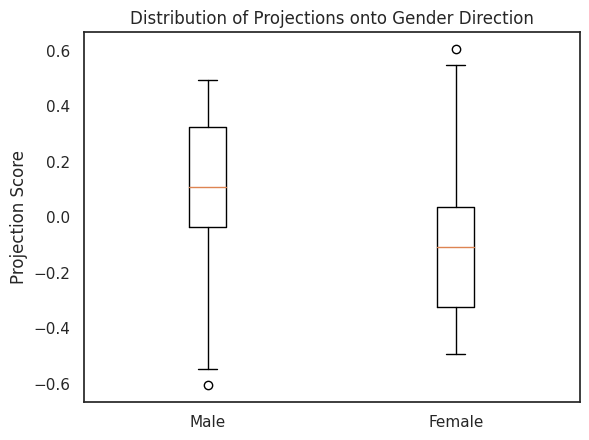

In [24]:
analyze_gender_bias_in_embeddings(words_of_interest, gender_direction, counter_fact_embeddings)

In [25]:
average_cosine_similarity(current_embeddings, counter_fact_embeddings, words_of_interest)

0.036584165

# Algorithm

## Action Helper Functions

### General

In [31]:
def mean_vector(embeddings, words):
    """Calculate the mean vector for a list of words."""
    vectors = [embeddings[word] for word in words if word in embeddings]

    if len(vectors) == 0:
        dim = 100
        return np.zeros(dim)
    else:
        return np.mean(vectors, axis=0)

def calculate_gender_direction(embeddings, male_words, female_words):
    """Calculate the gender direction based on differences between male and female word vectors."""
    male_vector = mean_vector(embeddings, male_words)
    female_vector = mean_vector(embeddings, female_words)
    gender_direction = male_vector - female_vector
    return gender_direction / np.linalg.norm(gender_direction)


def calculate_single_embedding_bias(word_embedding, gender_direction):
    """
    Calculate the bias of a single word embedding.

    Parameters:
    - word_embedding: The embedding vector of the word.
    - gender_direction: The gender direction vector for the embedding space.

    Returns:
    - bias: A measure of the gender bias of the word embedding.
    """
    normalized_gender_direction = gender_direction / np.linalg.norm(gender_direction)
    projection = np.dot(word_embedding, normalized_gender_direction)
    bias = abs(projection)
    return bias


def calculate_semantic_similarity(original_embedding, new_embedding):
    """
    Calculate the cosine similarity between the original and new embeddings of a word.

    Parameters:
    - original_embedding: np.array, the original embedding vector of the word.
    - new_embedding: np.array, the new embedding vector of the word after debiasing.

    Returns:
    - similarity: float, the cosine similarity between the original and new embeddings.
    """
    # Compute the dot product between the original and new embeddings
    dot_product = np.dot(original_embedding, new_embedding)

    # Compute the norm (magnitude) of each embedding
    original_norm = np.linalg.norm(original_embedding)
    new_norm = np.linalg.norm(new_embedding)

    # Calculate the cosine similarity
    similarity = dot_product / (original_norm * new_norm)

    return similarity


def check_debiasing_criterion(original_bias, new_bias, old_semantic_similarity, semantic_similarity, bias_threshold=0.1, similarity_threshold=0.8):
    """
    Check if the debiasing criteria are met for a word's embedding.

    Parameters:
    - original_bias: float, the original bias of the word's embedding.
    - new_bias: float, the calculated bias of the new embedding.
    - old_semantic_similarity: float, the previous cosine similarity between the original and new embeddings.
    - semantic_similarity: float, the current cosine similarity between the original and new embeddings.
    - bias_threshold: float, the maximum allowed bias for the word to be considered sufficiently debiased.
    - similarity_threshold: float, the minimum required semantic similarity to ensure the word's meaning is preserved.

    Returns:
    - done: bool, True if the debiasing criteria are met, False otherwise.
    """
    bias_reduced = new_bias < original_bias and new_bias <= bias_threshold
    similarity_preserved = semantic_similarity >= similarity_threshold

    # Check if both bias is reduced below the threshold and semantic similarity is maintained above its threshold
    done = bias_reduced and similarity_preserved

    return done



### Soft Debiasing

In [32]:
import numpy as np

def neutralize(word_vector, gender_direction, a=0.1):
    """
    Neutralize bias in the word vector by partially removing its projection on the gender direction.

    Parameters:
    - word_vector: The word vector to be neutralized.
    - gender_direction: The direction of gender bias in the embedding space.
    - a: A parameter between 0 and 1 that controls the extent of neutralization (default is 1.0 for full neutralization).
    """
    projection = np.dot(word_vector, gender_direction) * gender_direction
    return word_vector - a * projection

def apply_debiasing_action(word_vector, gender_direction, a=0.1):
    """
    Apply a specific debiasing action to a word vector.

    Parameters:
    - word: The target word.
    - word_vector: The vector representation of the word.
    - gender_direction: The calculated gender direction vector.
    - action: The debiasing action to apply ('neutralize' or 'equalize').
    """
    return neutralize(word_vector, gender_direction, a)

### Counterfactual Data Augmentation

In [33]:
def incremental_adjustment_cda(biased_embedding, cda_embedding, alpha=0.5):
    """
    Adjust biased embeddings towards CDA embeddings.

    Parameters:
    - biased_embeddings: Dict of original word embeddings.
    - cda_embeddings: Dict of word embeddings after applying CDA.
    - alpha: Step size for adjustment.

    Returns:
    - adjusted_embeddings: Dict of adjusted embeddings.
    """
    original_vec = biased_embedding
    cda_vec = cda_embedding
    direction = cda_vec - original_vec
    adjusted_vec = original_vec + alpha * direction
    return adjusted_vec

## Environment

In [43]:
import gym
from gym import spaces
import numpy as np

EMBEDDING_THRESHOLD = 0.95

class EmbeddingDebiasingEnv(gym.Env):
    """Custom Environment for Embedding Debiasing using Gym."""

    def __init__(self, embeddings, cda_embeddings, gender_direction, words_of_interest):
        super(EmbeddingDebiasingEnv, self).__init__()

        self.words = words_of_interest
        self.gender_direction = gender_direction
        self.embeddings = embeddings
        self.original_embeddings = {word: np.array(embeddings[word]).copy() for word in words_of_interest}
        self.cda_embeddings = cda_embeddings
        self.semantic_similarities = {word: 1.0 for word in words_of_interest}

        self.currentIndex = 0
        self.embedding_dim = len(embeddings[words_of_interest[0]])
        self.iteration_count = 0
        self.bias_scores = []
        self.similarity_scores = []

        self.action_space = spaces.Discrete(3)
        state_dim = self.embedding_dim + 300
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32)

        self.state_embeddings = self.original_embeddings.copy()

        self.state = None

        self.max_bias_change = 0.1
        self.min_bias_change = -0.1
        self.max_similarity_change = 0.1
        self.min_similarity_change = -0.1
        self.reset()

    def reset(self):
        self.currentIndex = 0
        np.random.shuffle(self.words)
        self.iteration_count = 0

        current_word = self.words[self.currentIndex]
        current_embedding = self.embeddings[current_word]
        bias = calculate_single_embedding_bias(current_embedding, self.gender_direction)
        self.semantic_similarities = {word: 1.0 for word in words_of_interest}
        previous_action = -1
        self.bias_scores = []
        self.similarity_scores = []
        self.state_embeddings = self.original_embeddings.copy()
        self.max_bias_change =
        self.min_bias_change = -0.1
        self.max_similarity_change = 0.1
        self.min_similarity_change = -0.1

        bias_vector = np.full((100,), bias)
        semantic_similarity_vector = np.full((100,), self.semantic_similarities[current_word])
        action_vector = np.full((100,), previous_action)

        self.state = np.concatenate((current_embedding, bias_vector, semantic_similarity_vector, action_vector))
        return self.state

    def check_done_condition(self):
        similarities = []
        for word in self.words:
            original_vec = self.original_embeddings[word]
            current_vec = self.state_embeddings[word]
            if np.linalg.norm(original_vec) == 0 or np.linalg.norm(current_vec) == 0:
                similarity = 0
            else:
                similarity = np.dot(original_vec, current_vec) / (np.linalg.norm(original_vec) * np.linalg.norm(current_vec))
            similarities.append(similarity)
        if np.mean(similarities) >= EMBEDDING_THRESHOLD:
            return True
        return False

    def update_normalization_ranges(self, bias_change, similarity_change):
        self.max_bias_change = max(self.max_bias_change, bias_change)
        self.min_bias_change = min(self.min_bias_change, bias_change)
        self.max_similarity_change = max(self.max_similarity_change, similarity_change)
        self.min_similarity_change = min(self.min_similarity_change, similarity_change)


    def normalize_value(self, value, min_val, max_val):
        if max_val == min_val:
            return value - min_val
        return (value - min_val) / (max_val - min_val)

    def step(self, action):
        self.iteration_count += 1
        current_word = self.words[self.currentIndex]
        current_embedding = self.embeddings[current_word]
        original_embedding = self.original_embeddings[current_word]
        original_bias = calculate_single_embedding_bias(current_embedding, self.gender_direction)

        if action == 0:  # Soft debiasing
            new_embedding = apply_debiasing_action(current_embedding, self.gender_direction, 0.1)
        elif action == 1:  # CDA
            new_embedding = incremental_adjustment_cda(current_embedding, self.cda_embeddings[current_word], 0.1)
        elif action == 2:  # Do nothing
          new_embedding = current_embedding

        new_semantic_similarity = calculate_semantic_similarity(original_embedding, new_embedding)
        new_bias = calculate_single_embedding_bias(new_embedding, self.gender_direction)

        if action == 2:  # Do nothing
          if original_bias < 0.9 and (self.semantic_similarities[current_word] > 0.9):
              reward = 0.01  # Reward for maintaining an already optimal state
          else:
              reward = -0.01  # Small penalty for inaction when action is needed
        else:
            # Calculate reward based on bias reduction and semantic similarity preservation
            bias_change = original_bias - new_bias
            similarity_change = self.semantic_similarities[current_word] - new_semantic_similarity

            self.update_normalization_ranges(bias_change, similarity_change)

            normalized_bias_reduction = self.normalize_value(bias_change, self.min_bias_change, self.max_bias_change)
            normalized_similarity_change = self.normalize_value(similarity_change, self.min_similarity_change, self.max_similarity_change)

            reward = 0.6 * normalized_bias_reduction - 0.4 * normalized_similarity_change

        self.embeddings[current_word] = new_embedding
        self.state_embeddings[current_word] = new_embedding
        bias_vector = np.full((100,), new_bias)
        semantic_similarity_vector = np.full((100,), new_semantic_similarity)
        action_vector = np.full((100,), action)

        self.state = np.concatenate((current_embedding, bias_vector, semantic_similarity_vector, action_vector))
        self.bias_scores.append(new_bias)
        self.similarity_scores.append(new_semantic_similarity)

        if self.currentIndex >= len(self.words) - 1:
          self.currentIndex = 0
          done = self.check_done_condition()
        else:
          self.currentIndex += 1
          done = False

        self.semantic_similarities[current_word] = new_semantic_similarity

        return self.state, reward, done, {}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Run Algorithm

episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
episode: 81
episode: 82
episode: 83
ep

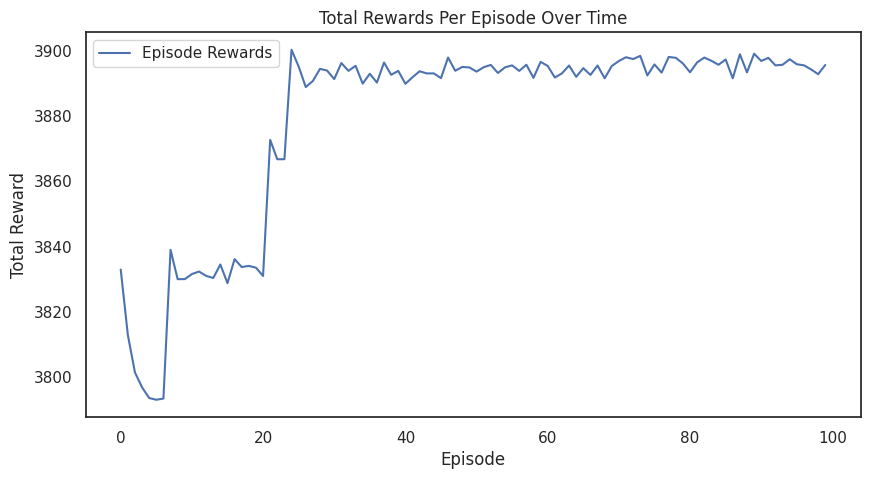

In [61]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

final_words = []
for word in words_of_interest:
    if word in current_embeddings and word in counter_fact_embeddings:
      final_words.append(word)

change_embeddings = current_embeddings.copy()

env = EmbeddingDebiasingEnv(change_embeddings, counter_fact_embeddings, gender_direction, final_words)

model = DQN("MlpPolicy", env, learning_rate=0.01, verbose=0, exploration_fraction=0.1, exploration_initial_eps=1.0,  exploration_final_eps=0.1)    # Final value of random action probability)

model.learn(total_timesteps=10000)

model.save("dqn_embedding_debiasing")

model = DQN.load("dqn_embedding_debiasing")

num_episodes = 100
episode_rewards = []

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    print("episode: {}".format(episode))

    for i in range(10000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    episode_rewards.append(total_reward)

plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards Per Episode Over Time')
plt.legend()
plt.show()

## Result Analysis

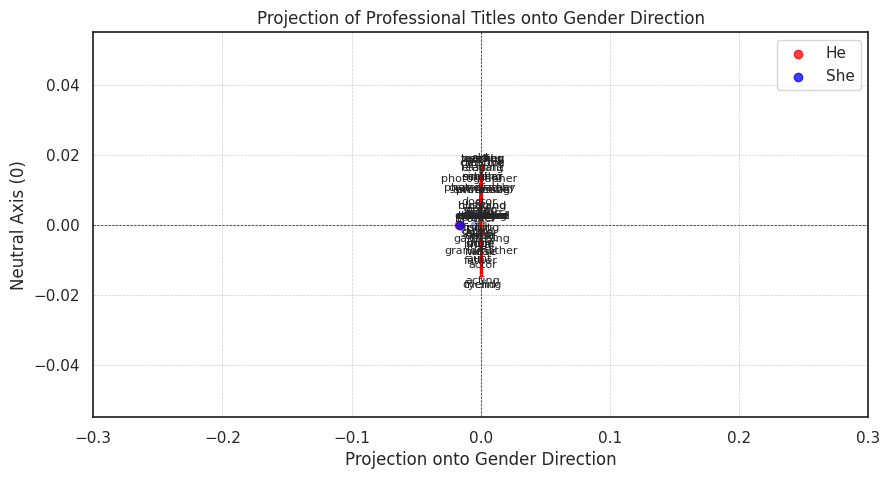

In [62]:
plot_gender_direction_projection(change_embeddings, final_words, gender_direction, ['he', 'she'])

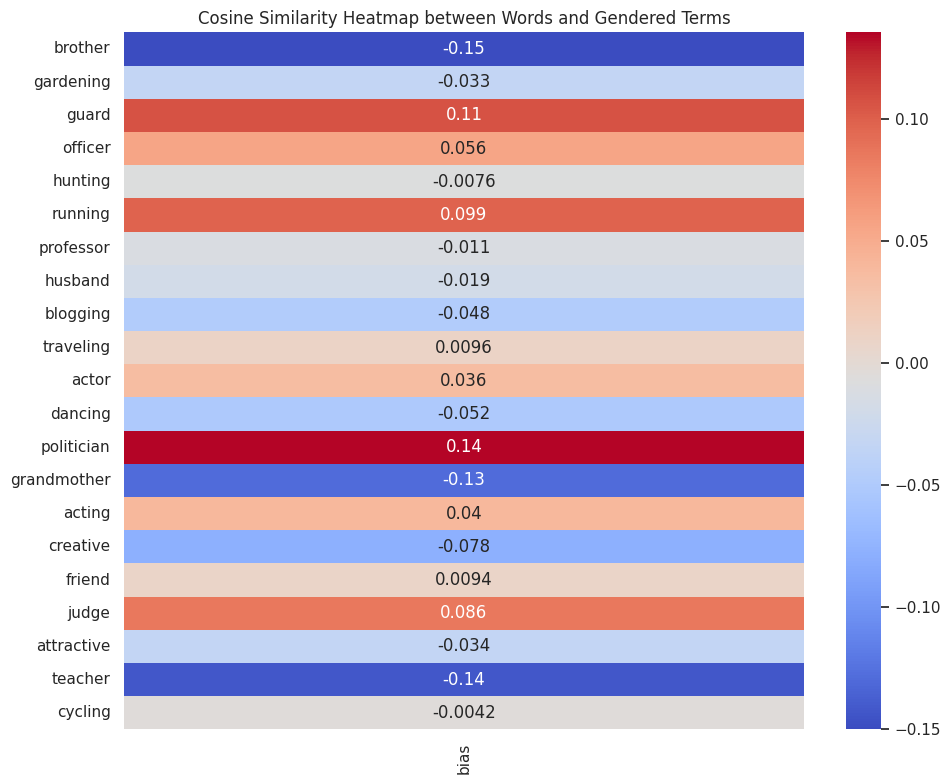

In [67]:
generate_cosine_similarity_heatmap(final_words[:21], change_embeddings)

Male projections normality: ShapiroResult(statistic=0.1689668893814087, pvalue=3.2394268833205834e-17)
Female projections normality: ShapiroResult(statistic=0.16896682977676392, pvalue=3.2394268833205834e-17)
Mann-Whitney U test p-value: 0.007888186811730253


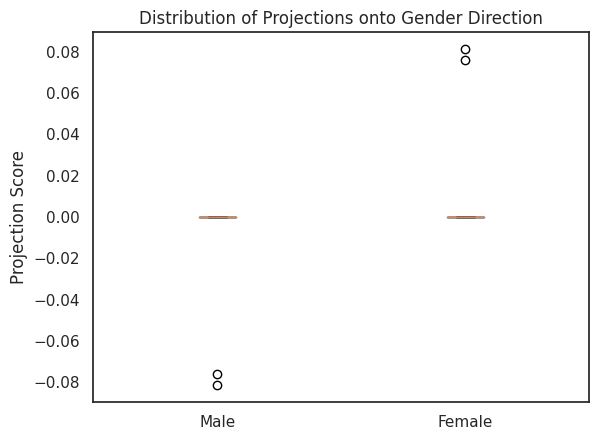

In [55]:
analyze_gender_bias_in_embeddings(final_words + ['he'] + ['she'], gender_direction, change_embeddings)